In [2]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper', 'ULTIMA COSA', 'PG')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [3]:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [4]:
#Fix params
#L_bar = 0.90
beta = 1

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour


In [5]:
from scipy.stats import chi2

def chi2_threshold(N, p, confidence):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])
p = 3
confidence_level = 0.683  # 68.3% confidence threshold

chi2_th = chi2_threshold(N, p, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th:.5f}")
print(1+np.sqrt(2/(N-p)))


Reduced chi-square threshold for 68.30000000000001% confidence: 1.01610
1.0344622758397788


# PG model analysis

In [6]:
#PG MODEL
#r_min = 1
#s_min = 2

model = 'PG'
#H0_values = np.linspace(60,80,20)[::-1] 
#L_bar_values = np.logspace(-1,1,20)
#Mabs_values = np.linspace(-21,-18.5,20)

H0_values = np.linspace(60,80,50)[::-1] 
L_bar_values = np.logspace(-1,1,50)
Mabs_values = np.linspace(-21,-18.5,50)
print(H0_values, L_bar_values, Mabs_values)

#r = 1; s = 2 
r = 1; s = 3 
#r = 1; s = 4 

matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_chi2_BETA_r={1}_s={2}_{0}.npy'.format(model, r, s)))
matrix_gila_aou = np.load(os.path.join(path_data, 'matrix_aou_BETA_r={1}_s={2}_{0}.npy'.format(model, r, s)))


[80.         79.59183673 79.18367347 78.7755102  78.36734694 77.95918367
 77.55102041 77.14285714 76.73469388 76.32653061 75.91836735 75.51020408
 75.10204082 74.69387755 74.28571429 73.87755102 73.46938776 73.06122449
 72.65306122 72.24489796 71.83673469 71.42857143 71.02040816 70.6122449
 70.20408163 69.79591837 69.3877551  68.97959184 68.57142857 68.16326531
 67.75510204 67.34693878 66.93877551 66.53061224 66.12244898 65.71428571
 65.30612245 64.89795918 64.48979592 64.08163265 63.67346939 63.26530612
 62.85714286 62.44897959 62.04081633 61.63265306 61.2244898  60.81632653
 60.40816327 60.        ] [ 0.1         0.10985411  0.12067926  0.13257114  0.14563485  0.15998587
  0.17575106  0.19306977  0.21209509  0.23299518  0.25595479  0.28117687
  0.30888436  0.33932218  0.37275937  0.40949151  0.44984327  0.49417134
  0.54286754  0.59636233  0.65512856  0.71968567  0.79060432  0.86851137
  0.95409548  1.04811313  1.1513954   1.26485522  1.38949549  1.52641797
  1.67683294  1.84206997  

### Important questions

In [7]:
#aou_threshold = 13.2
aou_threshold = 12.7
chi2_th = chi2_threshold(N, p, confidence_level)
print('Aou threhold: {}'.format(aou_threshold))
print('chi2 threhold: {}'.format(chi2_th))

masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)

print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou)/dof<=chi2_th))#should be True


Aou threhold: 12.7
chi2 threhold: 1.0160978536321694
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: True


In [8]:
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou)/dof))

#Double check
where_global_min = np.where(masked_data_with_aou==np.nanmin(masked_data_with_aou))
masked_data_with_aou[where_global_min]/dof

Minimum of the reduced $\chi^2$:0.8896283228868261


array([0.88962832])

In [9]:
masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, matrix_gila_chi2, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, masked_data_with_aou, np.nan)

print(masked_data_with_aou)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

[[[290865.30327398 254177.36336413 219978.68702671 ...   5710.17065663
    11339.71147804  19458.51587187]
  [269793.59501698 234494.67469265 201685.01794075 ...   8251.79535344
    15270.35576037  24778.17973972]
  [261251.06999659 226541.99253482 194322.17864547 ...   9736.59899649
    17345.00226597  27442.66910788]
  ...
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]]

 [[283270.72137289 247083.24661372 213385.03542698 ...   6623.4963171
    12753.50228919  21372.77183371]
  [262221.23744243 227440.66313797 195149.35240594 ...   9491.32011665
    17028.22654344  27054.39654267]
  [253649.8166201  219469.97604464 187779.3990416  ...  11132.37268729
    19270.01284308  29896.9165713 ]
  ...
  [            nan      

# 3D Monte Carlo sampling

[[[2.30929544e-45 4.79973998e-40 4.34659615e-35 ... 4.95823614e-04
   7.57447753e-05 5.04163644e-06]
  [2.61650149e-42 3.42079914e-37 1.94862168e-32 ... 2.12290757e-04
   2.03997543e-05 8.54106752e-07]
  [4.52812476e-41 4.86216981e-36 2.27475814e-31 ... 1.29334988e-04
   1.02073975e-05 3.51000227e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.91257527e-44 5.12242235e-39 3.92524689e-34 ... 3.65548579e-04
   4.72531308e-05 2.66139567e-06]
  [3.27564884e-41 3.60223627e-36 1.72599852e-31 ... 1.40367966e-04
   1.13456695e-05 3.99563322e-07]
  [5.72378144e-40 5.15091603e-35 2.01966466e-30 ... 8.11718472e-05
   5.36900886e-06 1.54730590e-07]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000

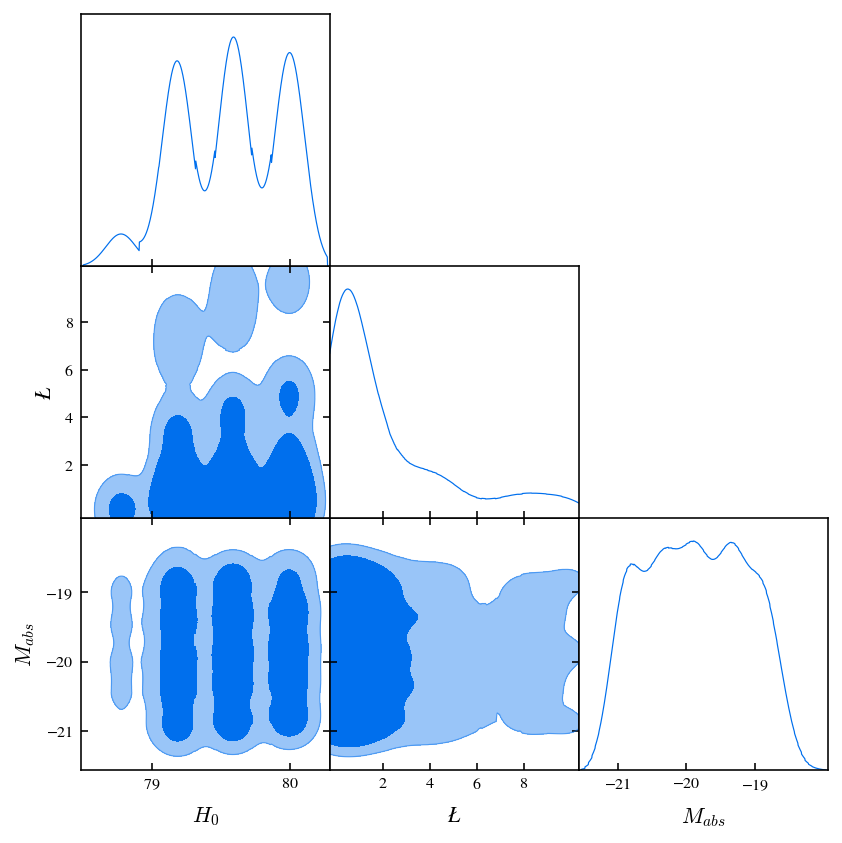

In [10]:
import getdist
import getdist.plots as gdplt
%matplotlib inline

x_vals = H0_values 
y_vals = L_bar_values 
z_vals = Mabs_values
#matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_gila_chi2.npy'))

#aux = matrix_gila_chi2.copy()/np.nanmin(matrix_gila_chi2)
#aux[np.isnan(matrix_gila_chi2)]=np.inf

aux = masked_data_with_aou.copy()/np.nanmin(masked_data_with_aou)
aux[np.isnan(masked_data_with_aou)]=np.inf

p3d = np.exp(-aux/2)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = int(1e5)  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]

samples_1 = samples.copy()



# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'],
                                         labels=[r'H_0', r'\L', r'M_{abs}'],
                                         settings={'mult_bias_correction_order':0,
                                                   'smooth_scale_2D':0.3,
                                                   'smooth_scale_1D':0.3}
                                         )

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
g.export(path_data+'triangle_gila_plot_{0}_r={1}_s={2}.pdf'.format(model, r, s))
plt.show()

79.55800408163266
2.240853179618717
-19.864021428571426


(array([17402.,  2941., 16157.,  4641., 17508.,  2938., 17650.,  3664.,
        14730.,  2369.]),
 array([-21.  , -20.75, -20.5 , -20.25, -20.  , -19.75, -19.5 , -19.25,
        -19.  , -18.75, -18.5 ]),
 <a list of 10 Patch objects>)

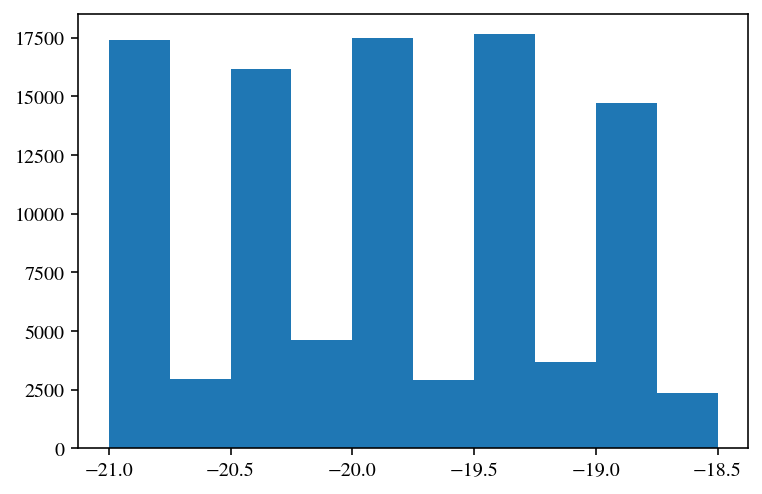

In [11]:
print(np.mean(samples[:,0]))
print(np.mean(samples[:,1]))
print(np.mean(samples[:,2]))
plt.hist(samples[:,2])

# Confidence intervals 

In [12]:
print('PG model')
print('Exponents: r = {0}, s = {1}'.format(r,s))
print(r'M abs: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,2]), np.std(samples[:,2])))
print(r'H0: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,0]), np.std(samples[:,0])))
print(r'$\L$: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,1]), np.std(samples[:,1])))


PG model
Exponents: r = 1, s = 3
M abs: -19.864021 \pm 0.712048
H0: 79.558004 \pm 0.364807
$\L$: 2.240853 \pm 2.755291


# Tension between PPS and CC

In [34]:
mean_A = np.array([np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:,2])])


cov_11 = np.cov(samples[:,0], samples[:,0])[0][1]
cov_22 = np.cov(samples[:,1], samples[:,1])[0][1]
cov_33 = np.cov(samples[:,2], samples[:,2])[0][1]
cov_12 = np.cov(samples[:,0], samples[:,1])[0][1]
cov_13 = np.cov(samples[:,0], samples[:,2])[0][1]
cov_23 = np.cov(samples[:,1], samples[:,2])[0][1]

cov_tot_A = np.array([[cov_11, cov_12, cov_13],
                      [cov_12, cov_22, cov_23],
                      [cov_13, cov_23, cov_33]])
print('Covariance matrix:')
print(cov_tot_A)
mean_B = mean_A
cov_tot_B = cov_tot_A

delta_theta = mean_A - mean_B
cov_tot = cov_tot_A + cov_tot_B

Covariance matrix:
[[ 1.33085754e-01  8.56366697e-02 -6.49963246e-03]
 [ 8.56366697e-02  7.59170460e+00  5.97745914e-03]
 [-6.49963246e-03  5.97745914e-03  5.07017095e-01]]


In [ ]:
from scipy.stats import chi2
from scipy.special import erfinv

# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)
alpha = np.dot(delta_theta.T,np.dot(A_matrix, delta_theta)) \

print(r'$Q_DM$: {}'.format(alpha))

PTE = chi2.sf(alpha, 3)
print('PTE: {}'.format(PTE))

n_sigma = from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

$Q_DM$: 0.0
PTE: 1.0
n_sigma:     0
